Now that we've explored a dataset, and written a first metric, let's take a look at some of the metrics already in the MAF library

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

In [2]:
# Connect to the database, set a directory to hold all the output
dbFile = 'baseline_v1.5_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
# Here's a good metric. from: https://github.com/lsst/sims_maf/blob/master/python/lsst/sims/maf/metrics/simpleMetrics.py
class Coaddm5Metric(metrics.BaseMetric):
    """Calculate the coadded m5 value at this gridpoint.
    """
    def __init__(self, m5Col='fiveSigmaDepth', metricName='CoaddM5', **kwargs):
        """Instantiate metric.

        m5col = the column name of the individual visit m5 data."""
        super(Coaddm5Metric, self).__init__(col=m5Col, metricName=metricName, **kwargs)

    def run(self, dataSlice, slicePoint=None):
        return 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.colname])))

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 491676 visits
Running:  ['opsim_CoaddM5_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r"" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 205 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 26.541  dipole: lon: 114.028, lat: -69.6533, amp: 0.434562
Plotting complete.


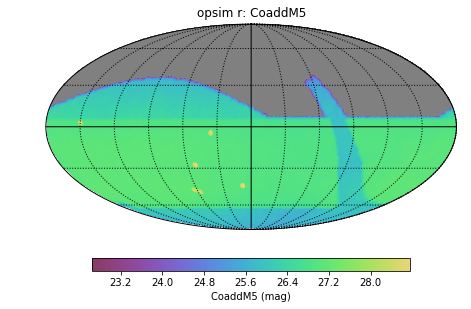

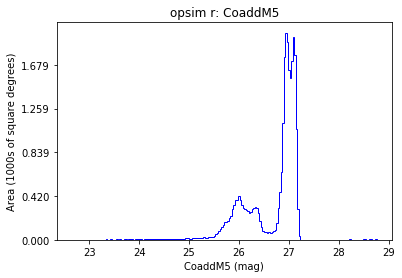

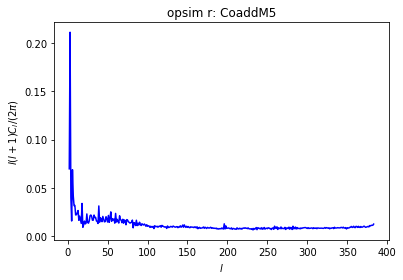

In [4]:
bundleList = []
# Need to set a single filter in the sql query, coadding different filters doesn't make sense
sql = 'filter="r"'
metric = metrics.Coaddm5Metric()
slicer = slicers.HealpixSlicer()
summaryStats = [metrics.MedianMetric()]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats))
bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [5]:
# Here, we load up a dust map
# from https://github.com/lsst/sims_maf/blob/master/python/lsst/sims/maf/metrics/exgalM5.py
from lsst.sims.photUtils import Sed, Bandpass

class ExgalM5(metrics.BaseMetric):
    """
    Calculate co-added five-sigma limiting depth after dust extinction.

    Uses photUtils to calculate dust extinction.

    Parameters
    ----------
    m5Col : str, opt
        Column name for five sigma depth. Default 'fiveSigmaDepth'.
    unit : str, opt
        Label for units. Default 'mag'.
    lsstFilter : str, opt
        Filter name for which to calculate m5 depth. Default 'r'.
        This is used to set the wavelength range over which to calculate dust extinction.
        Overrides wavelen_min/wavelen_max/wavelen_step if specified.
    wavelen_min : float, opt
        If lsstFilter is not specified, this can be used to set the minimum wavelength for dust extinction.
    wavelen_max : float, opt
        If lsstFilter is not specified, this can be used to set the maximum wavelength for dust extinction.
    """
    def __init__(self, m5Col='fiveSigmaDepth', metricName='ExgalM5', units='mag',
                 lsstFilter='r', wavelen_min=None , wavelen_max=None , **kwargs):
        # Set the name for the dust map to use. This is gathered into the MetricBundle.
        maps = ['DustMap']
        # Set the default wavelength limits for the lsst filters. These are approximately correct.
        waveMins = {'u':330.,'g':403.,'r':552.,'i':691.,'z':818.,'y':950.}
        waveMaxes = {'u':403.,'g':552.,'r':691.,'i':818.,'z':922.,'y':1070.}
        if lsstFilter is not None:
            wavelen_min = waveMins[lsstFilter]
            wavelen_max = waveMaxes[lsstFilter]

        self.m5Col = m5Col
        super().__init__(col=[self.m5Col], maps=maps, metricName=metricName, units=units, **kwargs)

        # Set up internal values for the dust extinction.
        testsed = Sed()
        testsed.setFlatSED(wavelen_min=wavelen_min, wavelen_max=wavelen_max, wavelen_step=1.0)
        testbandpass = Bandpass(wavelen_min=wavelen_min, wavelen_max=wavelen_max, wavelen_step=1.0)
        testbandpass.setBandpass(wavelen=testsed.wavelen,
                                 sb=np.ones(len(testsed.wavelen)))
        self.R_v = 3.1
        self.ref_ebv = 1.0
        # Calculate non-dust-extincted magnitude
        flatmag = testsed.calcMag(testbandpass)
        # Add dust
        self.a, self.b = testsed.setupCCM_ab()
        testsed.addDust(self.a, self.b, ebv=self.ref_ebv, R_v=self.R_v)
        # Calculate difference due to dust when EBV=1.0 (m_dust = m_nodust - Ax, Ax > 0)
        self.Ax1 = testsed.calcMag(testbandpass) - flatmag
        # We will call Coaddm5Metric to calculate the coadded depth. Set it up here.
        self.Coaddm5Metric = Coaddm5Metric(m5Col=m5Col)

    def run(self, dataSlice, slicePoint):
        """
        Compute the co-added m5 depth and then apply dust extinction to that magnitude.
        """
        m5 = self.Coaddm5Metric.run(dataSlice)
        # Total dust extinction along this line of sight. Correct default A to this EBV value.
        A_x = self.Ax1 * slicePoint['ebv'] / self.ref_ebv
        return m5 - A_x

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 491676 visits
Running:  ['opsim_ExgalM5_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r"" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 6622 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 25.4497  dipole: lon: 80.0238, lat: -30.2909, amp: 1.24368
Plotting complete.


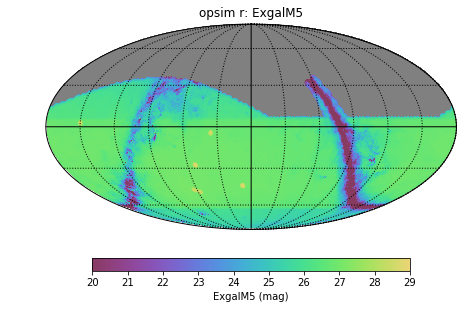

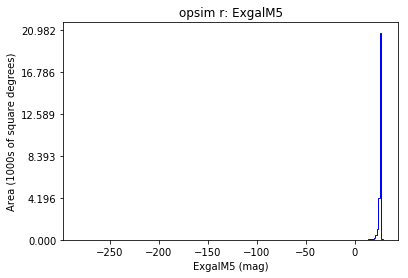

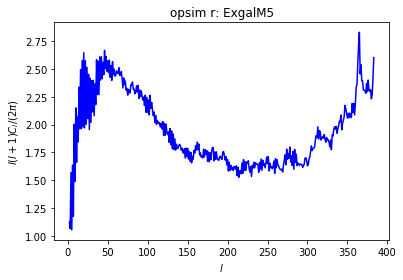

In [6]:
bundleList = []
# Need to set a single filter in the sql query, coadding different filters doesn't make sense
sql = 'filter="r"'
# Note we now need to set the filter on the metric as well.
metric = metrics.ExgalM5(lsstFilter='r')
# Here we set useCache=False. If we don't, MAF throws a warning that you probably want to do that
slicer = slicers.HealpixSlicer(useCache=False)
summaryStats = [metrics.MedianMetric()]
# Can get some skewed values, so let's set some plot limits
plotDict = {'colorMin': 20, 'colorMax': 29}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats))
bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

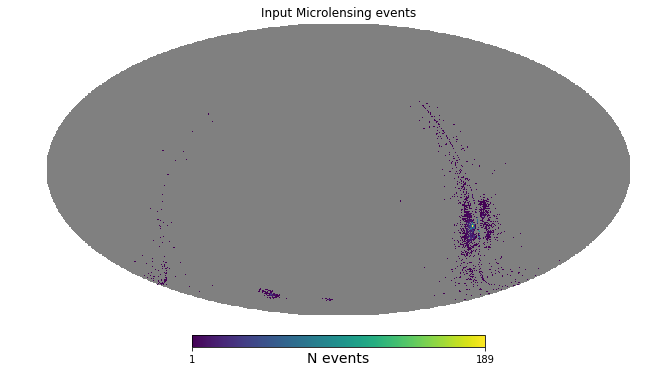

In [7]:
# My perosonal favorite, let's generate a population of transients, then see how many get observed

# Check out the code at: https://github.com/LSST-nonproject/sims_maf_contrib/blob/master/mafContrib/microlensingMetric.py

from mafContrib import MicrolensingMetric, generateMicrolensingSlicer, microlensing_amplification
from lsst.sims.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin

# generate a slicer with 10000 microlensing events
slicer = generateMicrolensingSlicer(min_crossing_time=1, max_crossing_time=10, n_events=10000)
# We can reach into the slicer and plot up the distribution of things
dist = _healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'], slicer.slicePoints['dec']*0+1, reduceFunc=np.sum)
hp.mollview(dist, title='Input Microlensing events', unit='N events')

Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'filter', 'fieldDec', 'night', 'fieldRA', 'observationStartMJD'].
Found 2224095 visits
Running:  ['opsim_MicrolensingMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


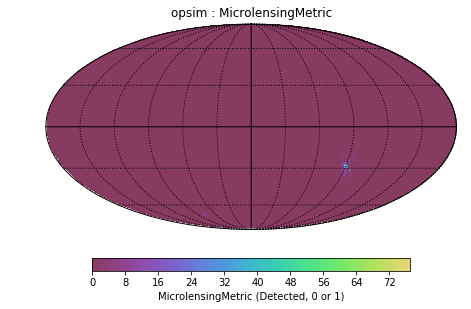

In [8]:
metric = MicrolensingMetric()
sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric(maskVal=0)]
bundle = metricBundles.MetricBundle(metric, slicer, sql,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)

bgroup = metricBundles.MetricBundleGroup([bundle], conn, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [9]:
bundle.summaryValues

{'Mean': 0.173}